In [55]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

In [56]:
# 准备数据(线性回归)
weight = 0.7
bias = 0.3

# create_data
start = 0
end = 1
step = 0.02

# 将行向量转化为列向量
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

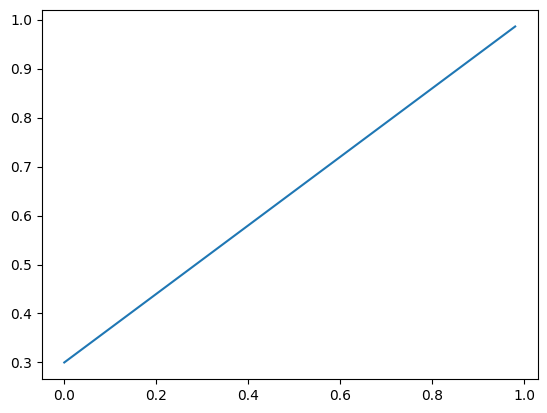

In [57]:
plt.plot(X, y)

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X.shape)
print(X_test.shape)  # 20%

torch.Size([50, 1])
torch.Size([10, 1])


In [ ]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

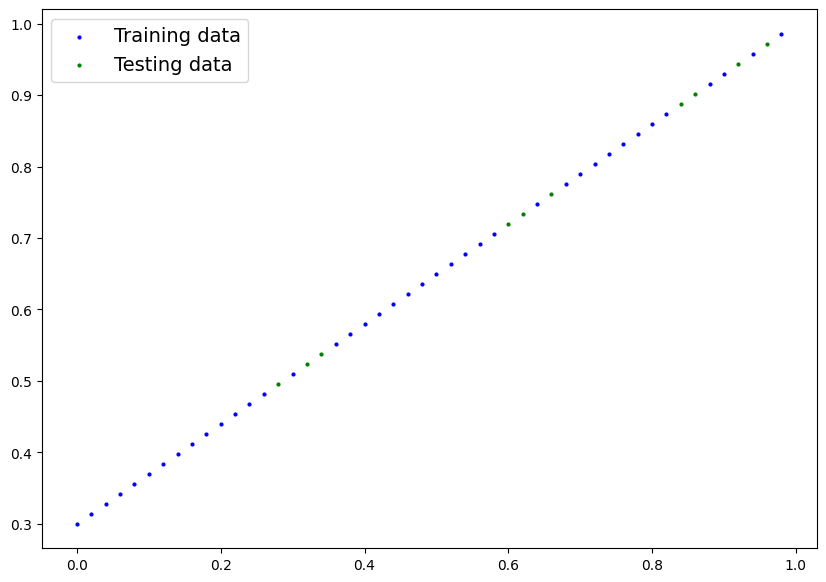

In [60]:
plot_predictions()

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 定义一个随机的参数，需要迭代优化
        self.weights = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float32)
        )

        self.bais = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float32)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x is the input data (e.g. training/testing features)
        """
        return self.weights * x + self.bais

In [62]:
my_module = LinearRegressionModel()

# 查看模型状态（参数值）
print(my_module.state_dict())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

my_module.to(device)

OrderedDict({'weights': tensor([-2.4661]), 'bais': tensor([0.3623])})
cuda


LinearRegressionModel()

In [63]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

# 查看所有的参数
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [64]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bais', tensor([0.1288]))])

In [ ]:
# 使用 inference_mode，说明我们不需要为这里的参数做反向传播 (requires_grad=Fasle)
with torch.inference_mode():
    y_preds = model_0(X_test)


# no_grad 也可以达到一样的效果，但是 inference_mode is better
with torch.no_grad():
    y_preds = model_0(X_test)

y_preds

tensor([[0.2366],
        [0.4116],
        [0.2433],
        [0.3376],
        [0.4184],
        [0.3510],
        [0.4386],
        [0.4520],
        [0.2231],
        [0.3308]])

In [66]:
y_preds = model_0(X_test)

y_preds

tensor([[0.2366],
        [0.4116],
        [0.2433],
        [0.3376],
        [0.4184],
        [0.3510],
        [0.4386],
        [0.4520],
        [0.2231],
        [0.3308]], grad_fn=<AddBackward0>)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

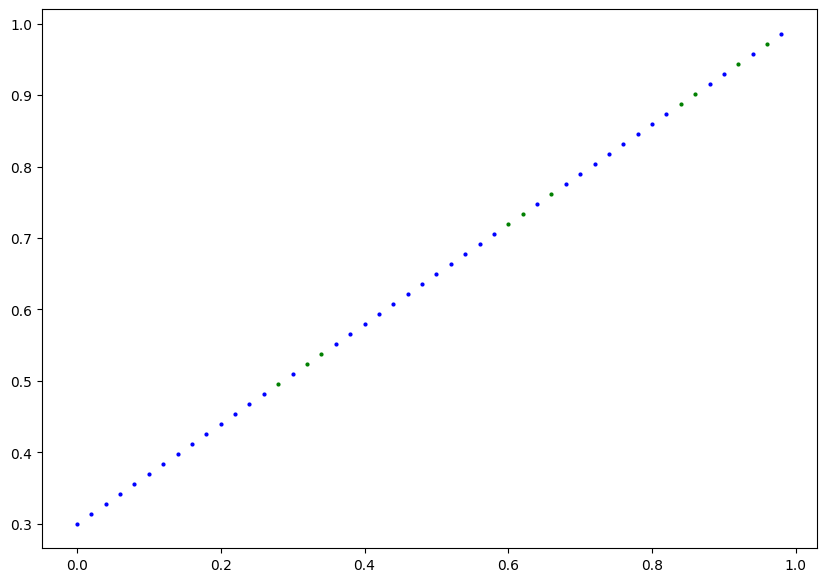

In [67]:
plot_predictions(predictions=y_preds)

In [ ]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup a optim
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)


In [69]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bais', tensor([0.1288]))])

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_0.to(device)

LinearRegressionModel()

In [72]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
             ('bais', tensor([0.1288], device='cuda:0'))])

In [74]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
%%time

epochs = 1000

for epoch in range(epochs):
    # 设置为 train 模式
    model_0.train()

    # 1. forward stage
    y_pred = model_0(X_train)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)
    print(loss)

    # 3. 清零梯度
    optimizer.zero_grad()

    # 4. 进行反向传播
    loss.backward()

    # 5. 进行参数优化
    optimizer.step()

    # 进入评估阶段（关闭 Dropout, Batchnorm 层）
    model_0.eval()

    # 不再记录 gradient
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

tensor(0.3356, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch: 0 | Loss: 0.3355882167816162 | Test loss: 0.40241917967796326
tensor(0.3344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3332, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3320, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3308, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3296, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3284, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3260, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3247, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3235, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch: 10 | Loss: 0.32354065775871277 | Test loss: 0.3895232081413269
tensor(0.3223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3199, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3187, device='cuda:0', grad_fn=<MeanBackward0>)
tensor

In [78]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6224], device='cuda:0')),
             ('bais', tensor([0.3373], device='cuda:0'))])

In [77]:
weight, bias

(0.7, 0.3)

In [85]:
from pathlib import Path

# create model dir
MYDRIVE = Path("/content/drive/MyDrive/Pytorch_learn")
MODEL_PATH = MYDRIVE / "models"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# model save path
MODEL_NAME = "workflow_model0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('/content/drive/MyDrive/Pytorch_learn/models/workflow_model0.pth')

In [ ]:
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

print("Completed!")

Completed!


In [ ]:
# 原模型结果
with torch.inference_mode():
    orgin_result = model_0(X_test)

orgin_result

tensor([[0.5364],
        [0.8601],
        [0.5489],
        [0.7231],
        [0.8725],
        [0.7480],
        [0.9099],
        [0.9347],
        [0.5115],
        [0.7107]], device='cuda:0')

In [ ]:
# 加载参数模型的结果
model_00 = LinearRegressionModel()
model_00.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_00.to(device)

with torch.inference_mode():
    save_model_result = model_00(X_test)

save_model_result  # 完全一致

tensor([[0.5364],
        [0.8601],
        [0.5489],
        [0.7231],
        [0.8725],
        [0.7480],
        [0.9099],
        [0.9347],
        [0.5115],
        [0.7107]], device='cuda:0')